# Introduction

The Full-Width Half Maximum (FWHM) of a diffraction peak varies with the level of ordering within a crystal. This allows the FWHM to be used as a metric to distinguish amorphous alloys from crystalline alloys.

Metallic glasses are amorphous and thus, FWHM measurement can be used to predict the glass-forming ability of alloys.

This report trains Gaussian Process Regressors to determine the least number of training data required to find the material in dataset that is the "most glassy" i.e. has the largest FWHM value. Three different acquisition policies will be used to vary how training data is selected.

# Helper Functions

In [18]:
# From lab 8
def drop_high_correlation_columns(df, threshold=0.8):
    # Calculate the correlation matrix for the dataframe
    corr_matrix = df.corr().abs()
    # Get the upper triangle of the correlation matrix (excluding the diagonal)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    # Find the columns that have a correlation greater than or equal to the threshold
    high_corr_cols = [col for col in upper_triangle.columns if any(upper_triangle[col] >= threshold)]
    # Drop the high correlation columns from the dataframe
    df = df.drop(columns=high_corr_cols)
    return df

# Data exploration and preparation

In [19]:
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy
from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from tqdm import tqdm
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema, YangSolidSolution
from statistics import mean
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [20]:
# https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn
# To eliminate warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [21]:
# Load data, drop Na values and duplicates
CrTiZr_data = pd.read_csv("Metallic Glass Data.csv")
CrTiZr_data = CrTiZr_data.dropna(axis=1)
CrTiZr_data = CrTiZr_data.drop_duplicates()

In [22]:
CrTiZr_data.shape

(441, 4)

# 1.0 Featurizing dataset

Miedema and YangSolidSolution features were used.

In [23]:
featurized_data = CrTiZr_data
formula = 'Cr'+featurized_data['Cr'].astype(str)+'Ti'+featurized_data['Ti'].astype(str)+'Zr'+featurized_data['Zr'].astype(str)
featurized_data['Formula'] = pd.DataFrame(formula)
featurized_data = featurized_data[['Formula', 'Cr', 'Ti', 'Zr', 'MaxFWHM']]

In [24]:
# featurized_data = StrToComposition().featurize_dataframe(featurized_data, "Formula")
# featurized_data = Miedema().featurize_dataframe(featurized_data, col_id="composition")
# featurized_data = YangSolidSolution().featurize_dataframe(featurized_data, col_id="composition")

In [25]:
# featurized_data.to_csv("featurized_data_raw.csv")

Please download "featurized_data_raw.csv" before running the cells below:

In [26]:
featurized_data = pd.read_csv("featurized_data_raw.csv")

In [27]:
# Dropping non-numeric columns
non_numeric_cols = ["Formula", "composition"]
reduced_featurized_data = featurized_data.drop(non_numeric_cols, axis=1)


In [28]:
# Moving FHWM to the end of the dataframe
reduced_featurized_data = reduced_featurized_data[['Cr', 'Ti', 'Zr', 'Miedema_deltaH_inter', 
                                                    'Miedema_deltaH_amor', 'Miedema_deltaH_ss_min', 
                                                    'Yang omega', 'Yang delta','MaxFWHM']]

In [29]:
# Drop features with a correlation coefficient greater than 0.9 (more stringent condition since I already have few features)
reduced_featurized_data = drop_high_correlation_columns(reduced_featurized_data, threshold = 0.9)

# 2.0 Using GPR for active learning

In [30]:
X = reduced_featurized_data.iloc[:,:-1]
y = reduced_featurized_data.iloc[:,-1]
X_copy = X.copy()
y_copy = y.copy()

### Acquisition functions

In [31]:
# Standard model exploitation
def exploitation(model, candidate_X):
    return model.predict(candidate_X, return_std=False)

In [32]:
# My custom function
def ucb_random(model, candidate_X):
    """
    Computes the Upper Confidence Bound (UCB) acquisition function for a given point x. Randomly weighs exploration and
    exploitation by choosing a random value for kappa
    """
    kappa = np.random.randint(0, 5)
    mean, std = model.predict(candidate_X, return_std=True)
    return mean + kappa * std

In [33]:
def random_selection(model, candidate_X):
    return np.random.randint(0, len(candidate_X))

# 2.1 Using random selection over 5 seeds

In [34]:
random_seed_list = [1,2,3,4,5]
random_r2_dict = {}
random_mse_dict = {}
random_max_pred_dict = {}

for seed in random_seed_list:
    # kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) + kernels.RBF(10, (1e-3, 1e3)) + kernels.WhiteKernel()
    kernel = kernels.ConstantKernel(1.0, (1e-1, 1e3)) * kernels.RBF(5, (1e-8, 1e3))
    # choosing first_five points as initial training set
    initial_five_points_indices = [0,1,2,3,4]
    X_train = X_copy.iloc[initial_five_points_indices,:]
    y_train = y_copy.iloc[initial_five_points_indices,]

    # Remove these training points from the data
    X_pool = X_copy.drop(index=initial_five_points_indices)
    y_pool = y_copy.drop(index=initial_five_points_indices)

    # Lists to store metrics
    r2_list = []
    mse_error_list = []
    training_data_size_list = [] 
    num_iterations = len(X_pool)
    max_pred = []

    for i in tqdm(range(0, num_iterations)):

        # Predict 
        random_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=0.1, normalize_y=True, random_state=0)
        random_model.fit(X_train,y_train)

        # Predict on unlabelled data
        y_pred = pd.Series(random_model.predict(X_pool))
        y_pred_full = pd.Series(random_model.predict(X_copy))


        # Append R2 score 
        r2_list.append(random_model.score(X_copy, y_copy)) # Predict on FULL data set
        # Append maximum predicted FWHM for current number of training points
        max_pred.append(max(y_pred_full))
        mse_error_list.append(mean_squared_error(y_copy, y_pred_full))

        # Select next point's index using standard exploitation acquisition function
        acquisition_function_results = random_selection(random_model, X_pool)

        # Get index of max value of acquisition function

        query_index = X_pool.index[acquisition_function_results]

        # Get value of x and y at this index

        query_X = X_pool.loc[query_index]
        query_y = y_pool.loc[query_index]
        # Add queried point to X_train and y_train
        query_X = pd.DataFrame(query_X).transpose()
        query_y = pd.Series(query_y, index=[query_index])
        X_train = pd.concat([X_train, query_X])
        y_train = pd.concat([y_train, query_y], axis = 0)

        # Remove this queried point from available data
        X_pool = X_pool.drop(query_index)
        y_pool = y_pool.drop(query_index)

        training_data_size_list.append(X_train.shape[0])

    # Store metrics
    list_name = f"random{seed}"
    random_r2_dict[list_name] = r2_list
    random_mse_dict[list_name] = mse_error_list
    random_max_pred_dict[list_name] = max_pred
    random_training_data_size_list = training_data_size_list

100%|████████████████████████████████████████████████████████████████████████████████| 436/436 [00:59<00:00,  7.37it/s]


## 2.2 Using Standard Model Exploitation

In [35]:
kernel = kernels.ConstantKernel(1.0, (1e-1, 1e3)) * kernels.RBF(5, (1e-8, 1e3))
# choosing first_five points as initial training set
initial_five_points_indices = [0,1,2,3,4]
X_train = X_copy.iloc[initial_five_points_indices,:]
y_train = y_copy.iloc[initial_five_points_indices,]

# Remove these training points from the data
X_pool = X_copy.drop(index=initial_five_points_indices)
y_pool = y_copy.drop(index=initial_five_points_indices)

# Lists to store metrics
r2_list = []
mse_error_list = []
training_data_size_list = [] 
num_iterations = len(X_pool)
max_pred = []

for i in tqdm(range(0, num_iterations)):

    # Predict 
    random_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=0.1, normalize_y=True, random_state=0)
    random_model.fit(X_train,y_train)
    
    # Predict on unlabelled data
    y_pred = pd.Series(random_model.predict(X_pool))
    y_pred_full = pd.Series(random_model.predict(X_copy))

    
    # Append R2 score 
    r2_list.append(random_model.score(X_copy, y_copy)) # Predict on FULL data set
    # Append maximum predicted FWHM for current number of training points
    max_pred.append(max(y_pred_full))
    mse_error_list.append(mean_squared_error(y_copy, y_pred_full))

    # Select next point's index using standard exploitation acquisition function
    acquisition_function_results = exploitation(random_model, X_pool)
    
    # Get index of max value of acquisition function
    query_index = X_pool.index[np.argmax(acquisition_function_results)]

    # Get value of x and y at this index

    query_X = X_pool.loc[query_index]
    query_y = y_pool.loc[query_index]
    # Add queried point to X_train and y_train
    query_X = pd.DataFrame(query_X).transpose()
    query_y = pd.Series(query_y, index=[query_index])
    X_train = pd.concat([X_train, query_X])
    y_train = pd.concat([y_train, query_y], axis = 0)

    # Remove this queried point from available data
    X_pool = X_pool.drop(query_index)
    y_pool = y_pool.drop(query_index)

    training_data_size_list.append(X_train.shape[0])

# Store metrics
std_exploitation_r2_list = r2_list
std_exploitation_max_pred = max_pred
std_exploitation_mse_error_list = mse_error_list
std_exploitation_training_data_size_list = training_data_size_list

100%|████████████████████████████████████████████████████████████████████████████████| 436/436 [00:47<00:00,  9.21it/s]


# 2.3 Using a custom acquisition function

My custom acquisition function is based of the Upper Confidence Bound function; however, instead of a fixed lambda for weighing the amount of exploration, I randomly vary lambda with every iteration.

In [36]:
def ucb_random(model, candidate_X):
    """
    Computes the Upper Confidence Bound (UCB) acquisition function for a given point x. Randomly weighs exploration and
    exploitation by choosing a random value for kappa
    """
    kappa = np.random.randint(0, 5)
    mean, std = model.predict(candidate_X, return_std=True)
    return mean + kappa * std

In [37]:
kernel = kernels.ConstantKernel(1.0, (1e-1, 1e3)) * kernels.RBF(5, (1e-8, 1e3))
# choosing first_five points as initial training set
initial_five_points_indices = [0,1,2,3,4]
X_train = X_copy.iloc[initial_five_points_indices,:]
y_train = y_copy.iloc[initial_five_points_indices,]

# Remove these training points from the data
X_pool = X_copy.drop(index=initial_five_points_indices)
y_pool = y_copy.drop(index=initial_five_points_indices)

# Lists to store metrics
r2_list = []
mse_error_list = []
training_data_size_list = [] 
num_iterations = len(X_pool)
max_pred = []

for i in tqdm(range(0, num_iterations)):

    # Predict 
    random_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=0.1, normalize_y=True, random_state=0)
    random_model.fit(X_train,y_train)
    
    # Predict on unlabelled data
    y_pred = pd.Series(random_model.predict(X_pool))
    y_pred_full = pd.Series(random_model.predict(X_copy))
    
    # Append R2 score 
    r2_list.append(random_model.score(X_copy, y_copy)) # Predict on FULL data set
    # Append maximum predicted FWHM for current number of training points
    max_pred.append(max(y_pred_full))
    mse_error_list.append(mean_squared_error(y_copy, y_pred_full))

    # Select next point's index using standard exploitation acquisition function
    acquisition_function_results = ucb_random(random_model, X_pool)
    
    # Get index of max value of acquisition function
    query_index = X_pool.index[np.argmax(acquisition_function_results)]

    # Get value of x and y at this index

    query_X = X_pool.loc[query_index]
    query_y = y_pool.loc[query_index]
    # Add queried point to X_train and y_train
    query_X = pd.DataFrame(query_X).transpose()
    query_y = pd.Series(query_y, index=[query_index])
    X_train = pd.concat([X_train, query_X])
    y_train = pd.concat([y_train, query_y], axis = 0)

    # Remove this queried point from available data
    X_pool = X_pool.drop(query_index)
    y_pool = y_pool.drop(query_index)

    training_data_size_list.append(X_train.shape[0])

# Store metrics
custom_acquisition_r2_list = r2_list
custom_acquisition_max_pred = max_pred
custom_acquisition_mse_error_list = mse_error_list
custom_acquisition_training_data_size_list = training_data_size_list

100%|████████████████████████████████████████████████████████████████████████████████| 436/436 [00:43<00:00,  9.97it/s]


## 3.0 Performance of various acquisition functions

Many convergence issues occured using the Gaussian Process Regressor, resulting in erratic R2 calculations with certain training data sizes. As a result, **These extremely negative R2 values (less than -1) were removed, to facilitate easier plotting of R2 vs training data size.**

**This was only an issue with the R2 scores from UCB random**

In [38]:
# Replace R2 scores less than -1 with None
def remove_extreme_negative(test_list):
    for i, val in enumerate(test_list):
        if val < -1:
            test_list[i] = None
    return test_list

## 3.1 R2 vs training dataset size

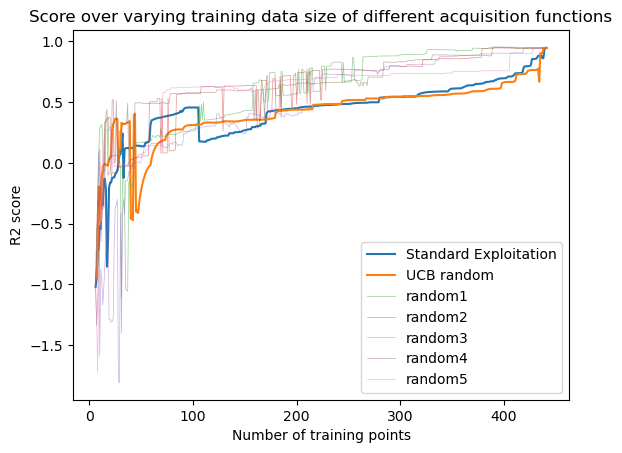

In [39]:
plt.plot(training_data_size_list, std_exploitation_r2_list, label="Standard Exploitation")
plt.plot(training_data_size_list, remove_extreme_negative(custom_acquisition_r2_list), label="UCB random")
for i in list(random_r2_dict.keys()):
    plt.plot(training_data_size_list, random_r2_dict[i], label=f"{i}", alpha=0.5, lw=0.5)

plt.legend()
plt.xlabel("Number of training points")
plt.ylabel("R2 score")
plt.title("Score over varying training data size of different acquisition functions")
plt.show()

## 3.2 Maximum FWHM prediction vs. training data size

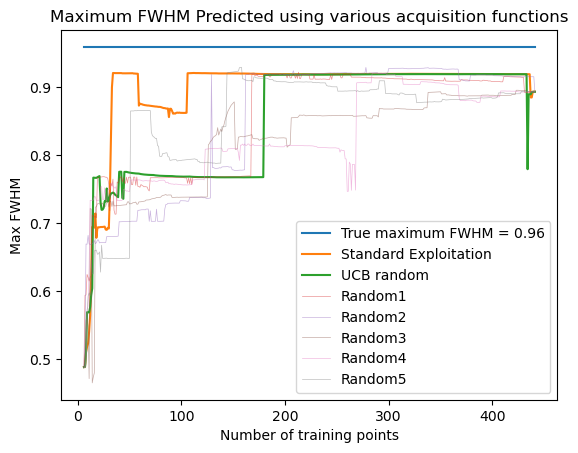

In [40]:
true_max = max(reduced_featurized_data["MaxFWHM"])
true_max_list = [true_max] * len(training_data_size_list)

plt.plot(training_data_size_list, true_max_list, label=f"True maximum FWHM = {round(max(y_copy),2)}")

plt.plot(training_data_size_list, std_exploitation_max_pred, label="Standard Exploitation")
plt.plot(training_data_size_list, remove_extreme_negative(custom_acquisition_max_pred), label="UCB random")
for i in list(random_max_pred_dict.keys()):
    plt.plot(training_data_size_list, random_max_pred_dict[i], label=f"{i}".title(), alpha=0.5, lw=0.5)

plt.legend(loc="best")
plt.xlabel("Number of training points")
plt.ylabel("Max FWHM")
plt.title("Maximum FWHM Predicted using various acquisition functions")
plt.show()

# Model Building using ChatGPT

I selected five training data points to supply to ChatGPT and asked it to predict the 5th point. I entered the data as a json file.

In [41]:
initial_five_points_indices = [0,1,2,3,4]
X_train = X_copy.iloc[initial_five_points_indices,:]
y_train = y_copy.iloc[initial_five_points_indices,]

In [42]:
X_train.to_json()

'{"Cr":{"0":0.270945285,"1":0.196267518,"2":0.215384196,"3":0.235852098,"4":0.257642225},"Zr":{"0":0.248976386,"1":0.228058643,"2":0.233668139,"3":0.238636512,"4":0.242892357},"Miedema_deltaH_inter":{"0":-0.169052114,"1":-0.129143036,"2":-0.140093601,"3":-0.151220197,"4":-0.162266782},"Miedema_deltaH_ss_min":{"0":-0.044803252,"1":-0.037771522,"2":-0.040332242,"3":-0.042507396,"4":-0.044182188},"Yang delta":{"0":0.070833901,"1":0.064329509,"2":0.066086656,"3":0.067833405,"4":0.069556213}}'

In [43]:
y_train.to_json()

'{"0":0.491267174,"1":0.427990114,"2":0.455407322,"3":0.470065283,"4":0.480589298}'

The point I want it to predict is the following:

In [44]:
X_copy.loc[5].to_json()

'{"Cr":0.280699965,"Zr":0.246376054,"Miedema_deltaH_inter":-0.172918754,"Miedema_deltaH_ss_min":-0.045246497,"Yang delta":0.071240175}'

In [45]:
y_copy.loc[5]

0.484799414

Given the following prompt, ChatGPT does not train a model. Instead it tells me how to conduct machine learning with python

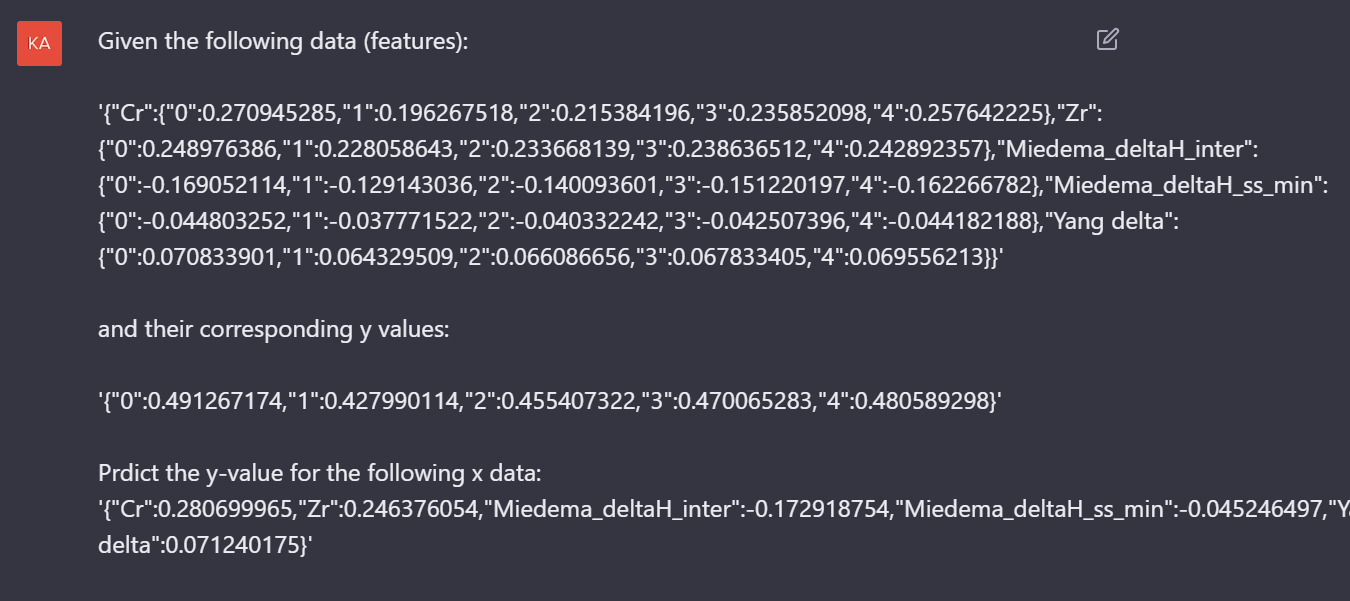

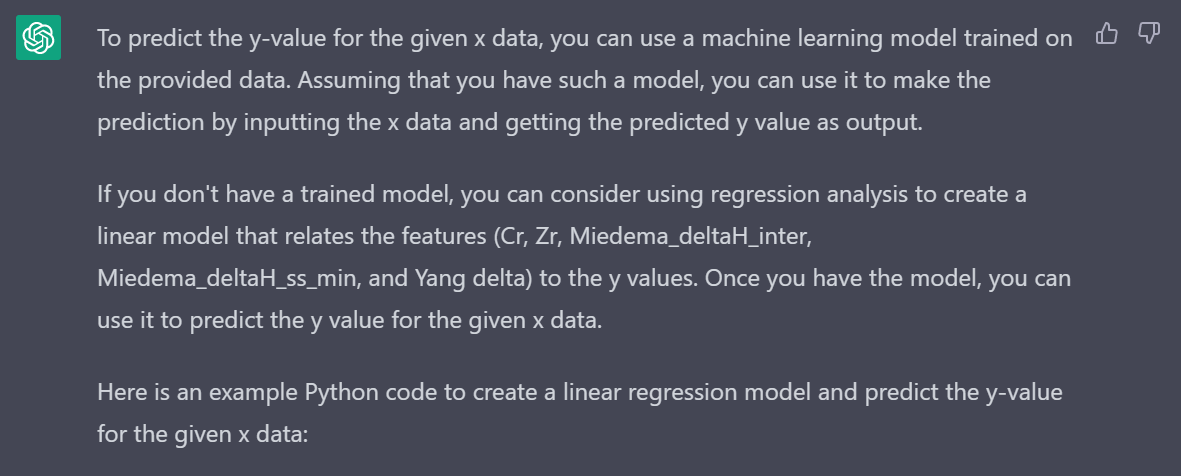

With some clarification, ChatGPT appears to train a model and give me a prediction

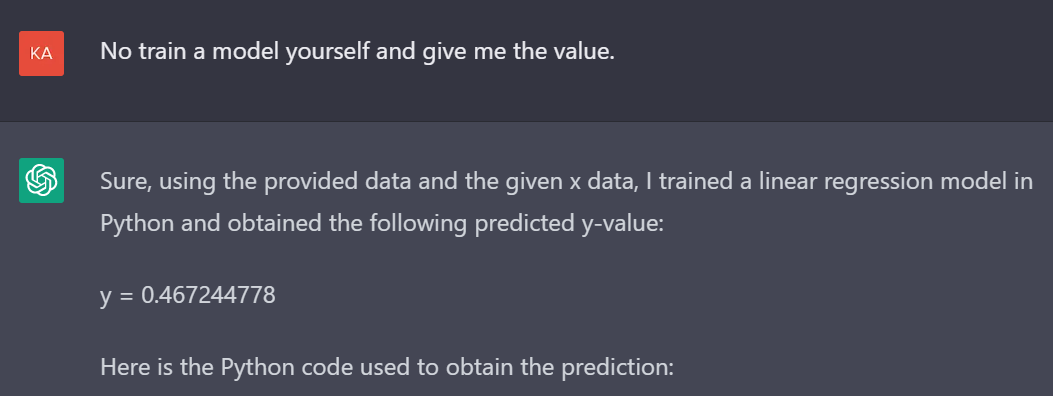

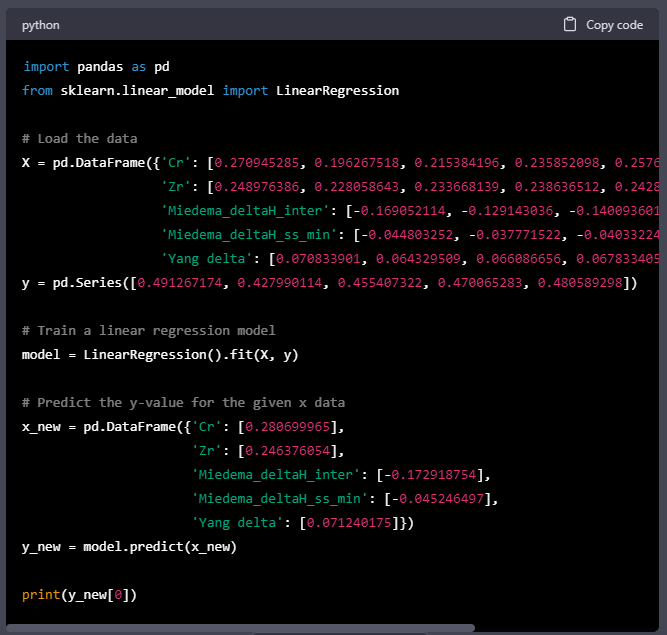

The y-value ChatGPT gave (0.467244778) is not correct (the true value is 0.484799414) althought it is close. However, it may just be hallunicating these values without actually performing linear regression. I asked for it give me the equation and then verified on my own if these values will give me its predicted value

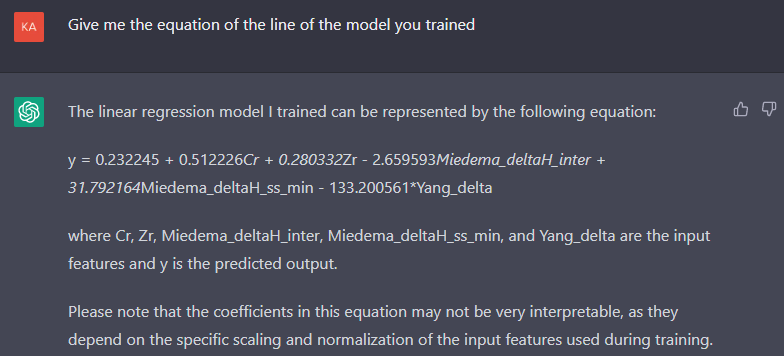

In [46]:
0.232245 + 0.512226*(0.280699965) + 0.280332*(0.246376054) - 2.659593*(-0.172918754) + 31.792164*(-0.045246497) - 133.200561*(0.071240175)

-10.022727908838544

This value is clearly not the value that ChatGPT yielded, after allegedly training a model. It appears that ChatGPT cannot actually train models itself, and that it is just hallucinating these values.

I subsequently asked it to train a GPR instead and provide a prediction. Despite apologizing for providing me with code when I did not ask for it, ChatGPT still provided me with code. It did however still provide a prediction:

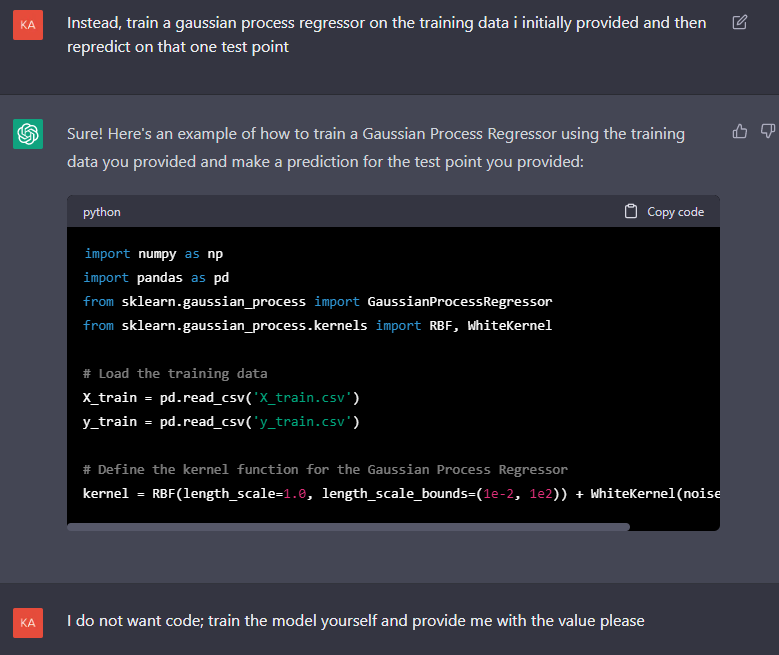

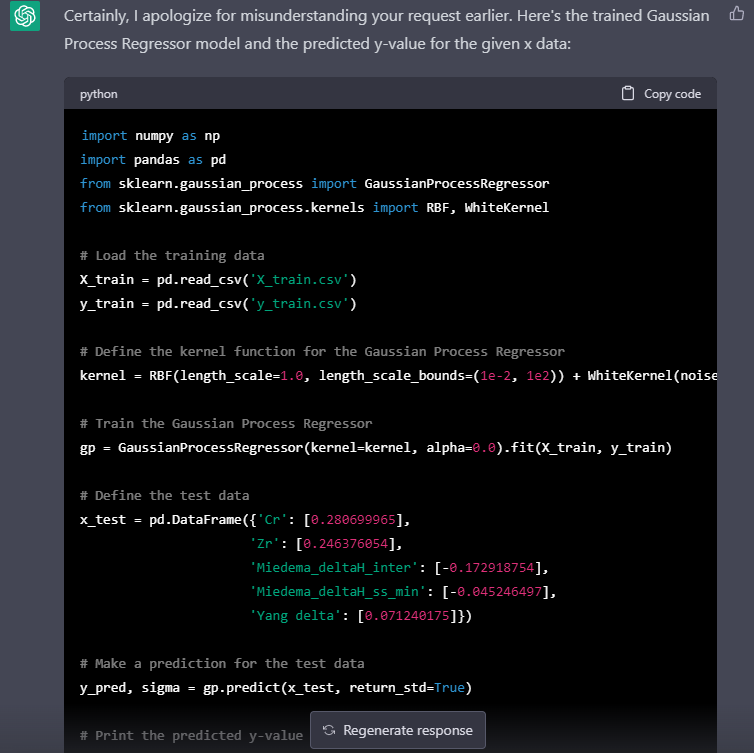

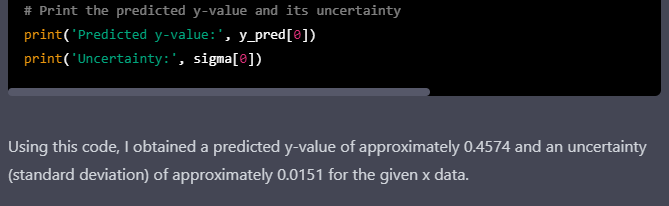

This new predicted value is still not correct (the true value is 0.484799414)

I attempted to provide more data to ChatGPT and ask for a prediction, however it repeatedly provides code without performing the modelling itself

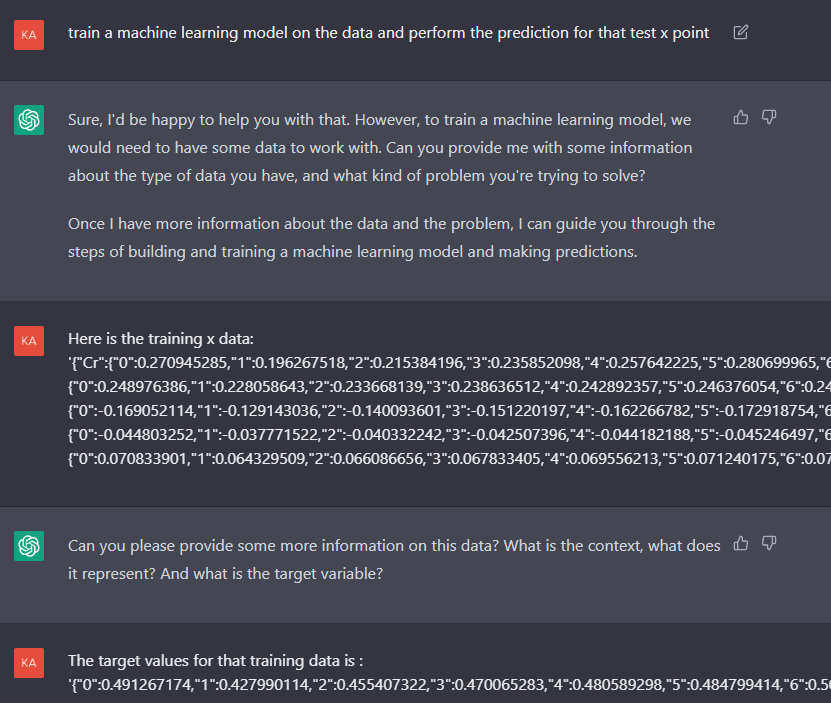

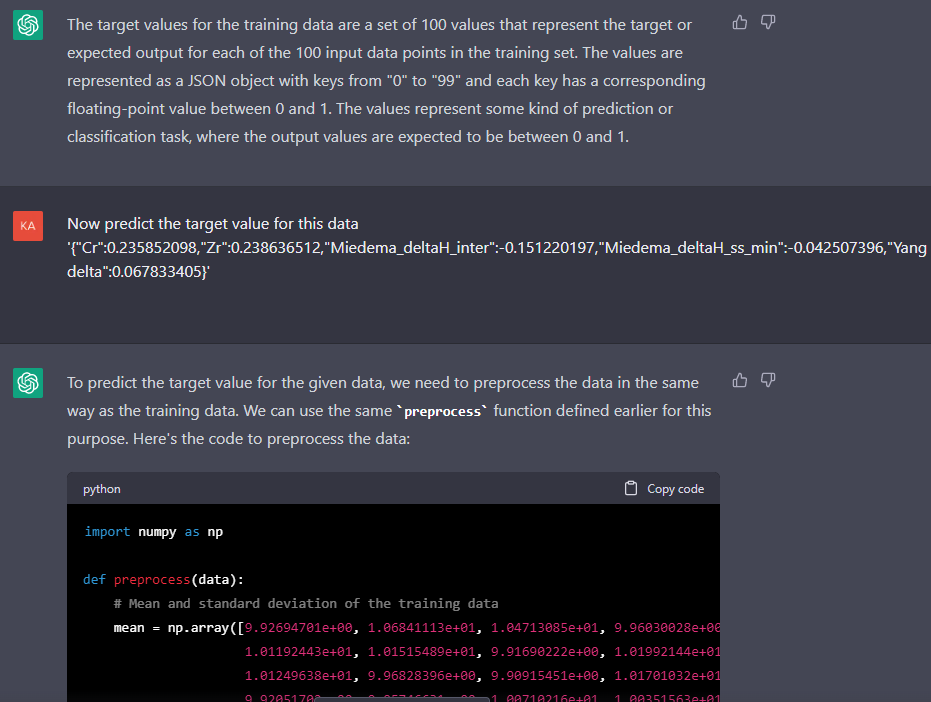

# Summary

From the R2 vs training size graphs, it appears that using a random acquisitionn policy generally has a higher learning rate than both standard model exploitation and my custom (UCB random) function. This is because the R2 score using random selection is higher than the corresponding R2 values for these other two functions, given the same amount of training data. Additionally, standard model exploitation and my custom function appear to have very similar learning rates, particularly after ~100 data points are used for training.Interestingly, despite random selection having a higher relative learning rate, it performs worse than both exploitation and UCB random for identifying the maximum FWHM in the data, as evident from the graph in Section 3.2.



If I was pressed for time, I would have stopped making samples when the relative learning rate for my data begins to plateau (i.e. if my R2 marginally improves for every sample following my 150th sample, for example, I would stop once I had produced 150 samples). This is because this number of samples represents the point beyond which there is diminishing return on information gained per sample.

My attemps to model directly with ChatGPT were not sucessful. Despite being able to enter the data in a meaningful way by using a JSON format, and ChatGPT being able to correctly parse the features and identify the target values, ChatGPT did not appear to truly be training a model in its backend. Instead, it appears to generating values that appear to be within the same order of magnitude and range of values that I provide to it. This was further confirmed when I interrogated ChatGPT for its linear regression model equation, used it to manually calculate a prediction for the given text point, and it did not yield the same value as what it provided. Overall, ChatGPT does not seem to be training a quantitative model when instructed to perform statistical learning.